# Predicting ASD diagnosis from Genetic Data

0/1 classification with logistic regression is a well-studied problem.  In order to familiarize myself with standard logistic regression techniques, I'm going to start with the simple two-class classification problem of predicting ASD/non-ASD diagnosis from genotype.

Author: Rachael Caelie "Rocky" Aikens

Created: Oct 25, 2017

Version: 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import f1_score, make_scorer, roc_curve, accuracy_score, confusion_matrix, roc_auc_score
import random

## Data preprocessing

We have genotype information for siblings from the Agre and Simons Simplex Collection, which has been featurized into a binary matrix (described below). In addition to that, we have imputed ASD/non-ASD labels and ADOS/ADI-R scores for a subset of those individuals.

### Feature Data (Genotype)

The input data is represented as a binary matrix.  There are a couple different representations we can use here, but to start I will use 1 = loss of function variant(compound het or homozygous alternate), 0 = no loss of function variant.

In [2]:
# load input feature dataset for Agre
Agre_asd = pd.read_csv("data/v34_lof_asd_af0.50.txt", index_col=0).transpose()
Agre_ctrl = pd.read_csv("data/v34_lof_typical_af0.50.txt", index_col=0).transpose()

print ("Cases: ", Agre_asd.shape[0])
print ("Controls: ", Agre_ctrl.shape[0])

Cases:  1616
Controls:  349


In [3]:
# load input feature dataset for SSC
SSC_asd = pd.read_csv("data/SSC_lof_asd_af0.50.txt", index_col=0).transpose()
SSC_ctrl = pd.read_csv("data/SSC_lof_typical_af0.50.txt", index_col=0).transpose()

print ("Cases: ", SSC_asd.shape[0])
print ("Controls: ", SSC_ctrl.shape[0])

Cases:  517
Controls:  518


In [4]:
# merge SSC and Agre data
X_asd = pd.concat([SSC_asd, Agre_asd], axis = 0).fillna(0)
X_ctrl = pd.concat([SSC_ctrl, Agre_ctrl], axis = 0).fillna(0)

In [5]:
X = pd.concat([X_asd, X_ctrl], axis=0)
print ("Total cases: ", X_asd.shape[0])
print ("Total controls: ", X_ctrl.shape[0])
print ("Features (ie. genes): ", X.shape[1])
print ("Missing Values: ", int(X.isnull().values.any()))

Total cases:  2133
Total controls:  867
Features (ie. genes):  1109
Missing Values:  0


### Target Data (ASD/non-ASD diagnosis)

We have a file that Kelley has made with inferred Autism/Control diagnosis for the individuals in the iHart study.  We will try and predict diagnosis 0 = Control, 1 = Austism.

In [6]:
y = pd.read_csv("data/all_samples_filtered_labels.csv", usecols = ['identifier','diagnosis'], index_col=0)

In [7]:
# shift y to a 0/1 representation for Control/ASD
y["diagnosis"] = np.where(y['diagnosis'] == 'Autism', 1, 0)

### Filtering for Overlap

Our phenotype labels y may not perfectly overlap with our genotype data, X.

In [8]:
# get lists of individuals in X and Y
m_x = X.index.values.tolist()
m_x_asd = X_asd.index.tolist()
m_x_ctrl = X_ctrl.index.tolist()
m_y = y.index.values.tolist()

# check subject overlap between X and Y
print ("%d subjects in X are not in y.  Of these, %d are cases and %d are controls." % (len(set(m_x) - set(m_y)), len(set(m_x_asd) - set(m_y)), len(set(m_x_ctrl) - set(m_y))))

# make a list of Subject IDs with overlap
subjects = list(set(m_x) & set(m_y))
print ("This leaves %d subjects: %d cases and %d controls." % (len(subjects), len(set(m_x_asd) & set(m_y)), len(set(m_x_ctrl)&set(m_y))) )

868 subjects in X are not in y.  Of these, 5 are cases and 863 are controls.
This leaves 2132 subjects: 2128 cases and 4 controls.


**Note:** The set of "cases" and "controls" appear to be differently defined between the iHart Phenotype labels (i.e. our `y` labels) and the CGT matrix labels (i.e. our `X` features). 

You can notice that the majority of controls don't appear in our phenotype information dataset. This is because ADOS\ADI-R was not administered to many controls from SSC and Agre. Since we're interested in classifying ASD/non-ASD, for our purposes it is not necessary to exclude these individuals because we do not necessarily need any phenotype information outside of diagnosis. Rather, we can infer that all individuals in a 'control' CGT matrix without ADOS/ADI-R information have a non-ASD diagnosis.

In [9]:
to_add = list(set(m_x_ctrl) - set(m_y))
y_ctrl = pd.DataFrame(np.zeros(len(to_add),), columns = ['diagnosis'],index = to_add)
y = pd.concat([y, y_ctrl], axis = 0)
subjects = subjects + to_add

In [10]:
# redefine X and Y to contain only the subjects we want
X = X.ix[subjects]
y = y.ix[subjects]

# check we have the same subject IDs in the same order for X and Y
print (y.index.values.tolist() == X.index.values.tolist())
y = y.ix[:,0]
print (y.value_counts())

True
1.0    2088
0.0     907
Name: diagnosis, dtype: int64


C:\Users\Christine\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app
C:\Users\Christine\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()
C:\Users\Christine\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


One thing that's probably going to be an issue for this experiment is that there are very few controls for whom we have both genetic and ADOS/ADI-R information.  This is going to mean that a random classifier performs with fairly high accuracy, just because classifying most or all individuals as autistic is a effective strategy when we have so few negatives. 

## Data Splitting

Since we have ~1,600 examples, I'm going to hold out 20% of the data as a test set and then do 5 fold cross validation using built-in sklearn methods.

In [11]:
random.seed(143)
from class_SibKFold import SibKFold
skf = SibKFold(5, X)
train_ids, test_ids = skf.split(X)[0]
X_train = X.ix[train_ids]
X_test = X.ix[test_ids]
y_train = y.ix[train_ids]
y_test = y.ix[test_ids]

print (len(test_ids))
print (len(train_ids))

599
2396


C:\Users\Christine\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Christine\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


## Logistic Regression

### Model and training parameters

I am going to implement logistic regression using sklearn.

We'll start with the following parameters:

**Cost function**
- Penalty distance metric = $L_1$
- Dual formulation = `False` (better when $m$ > $n$)
- c ($\frac{1}{\lambda}$ for regularization) = 1

**Optimization Algorithm**
- tolerance for convergence = $1\times 10^{-4}$
- optimization algorithm = liblinear

**Model definition**
- fit_intercept = `True`
- class weighting = None
- multi_class = 'ovr'

More or less, these are the sklearn defaults, which I can tune at a later point.  One exception is that I have used l1 instead of l2 regularization. There's a convincing arguement to be made the l1 regularization is more sensible than l2 for this genetic problem.  The critical difference is that l1 tends to shrink all parameters to zero, while l2 tends to shrink specifically large parameters.  In a genetic model, we expect that some genes are highly informative, while some are not informative at all.  Thus, we would rather use an absolute, rather than a squared loss.

I've built a python object called EvalLR which will help me run cross validation for my regression models and output plots and statistics.  The following code initializes an EvalLR with the logistic regression model described above:

In [15]:
# Import EvalLR
import class_EvalLR
#reload(class_EvalLR)
from class_EvalLR import EvalLR

### First-pass 5-fold cross validation

To start, I'm going to run 5-fold cross validation on the training set. The following code does the necessary split for the data and prints the train and test scores for each fold using the f1 scoring metric.  Recall that this is:

$$F_1 = \frac{2}{\frac{1}{r} + \frac{1}{p}} = \frac{2rp}{r + p},$$

where $r$ represents the *recall* or *sensitivity* of the classification and $p$ represents the *precision*. 

In [16]:
evalr = EvalLR(X_train, y_train)


Running cross validation for fold 1:
Train Score: 0.817112 Test Score: 0.593381
AU-ROC 0.593380614657

Optimum threshold to maximize training accuracy: 0.57867474074
F1: 0.779527559055
Accuracy: 0.673469387755
Confusion Matrix:
 [[ 33  75]
 [ 37 198]]


C:\Users\Christine\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Optimum threshold to maximize f1: 0.504228461192
F1: 0.790170132325
Accuracy: 0.67638483965
Confusion Matrix:
 [[ 23  85]
 [ 26 209]]
None


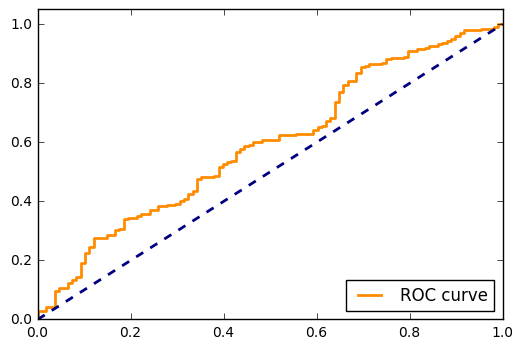


Running cross validation for fold 2:
Train Score: 0.822403 Test Score: 0.532992
AU-ROC 0.532991619884

Optimum threshold to maximize training accuracy: 0.562760098481
F1: 0.758349705305
Accuracy: 0.64139941691
Confusion Matrix:
 [[ 27  75]
 [ 48 193]]

Optimum threshold to maximize f1: 0.505568331642
F1: 0.781132075472
Accuracy: 0.661807580175
Confusion Matrix:
 [[ 20  82]
 [ 34 207]]
None


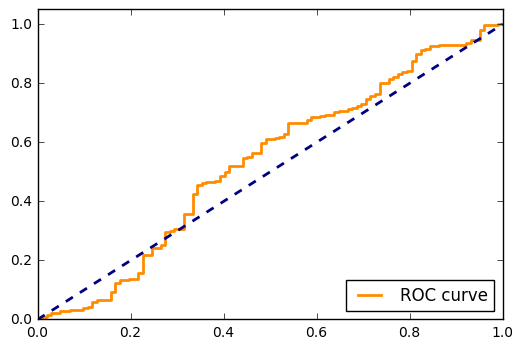


Running cross validation for fold 3:
Train Score: 0.819964 Test Score: 0.529701
AU-ROC 0.529700991366

Optimum threshold to maximize training accuracy: 0.586799669967
F1: 0.716599190283
Accuracy: 0.590643274854
Confusion Matrix:
 [[ 25  81]
 [ 59 177]]

Optimum threshold to maximize f1: 0.562667207076
F1: 0.734126984127
Accuracy: 0.608187134503
Confusion Matrix:
 [[ 23  83]
 [ 51 185]]
None


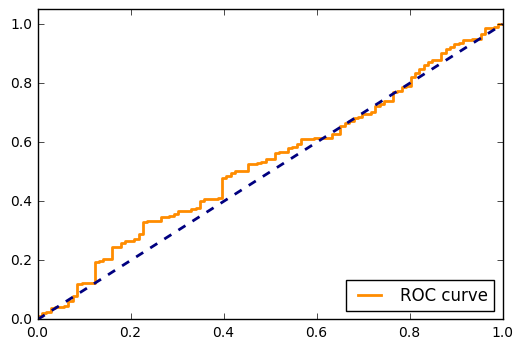


Running cross validation for fold 4:
Train Score: 0.812963 Test Score: 0.632149
AU-ROC 0.63214869281

Optimum threshold to maximize training accuracy: 0.558045938757
F1: 0.803846153846
Accuracy: 0.701754385965
Confusion Matrix:
 [[ 31  71]
 [ 31 209]]

Optimum threshold to maximize f1: 0.492665265971
F1: 0.809792843691
Accuracy: 0.704678362573
Confusion Matrix:
 [[ 26  76]
 [ 25 215]]
None


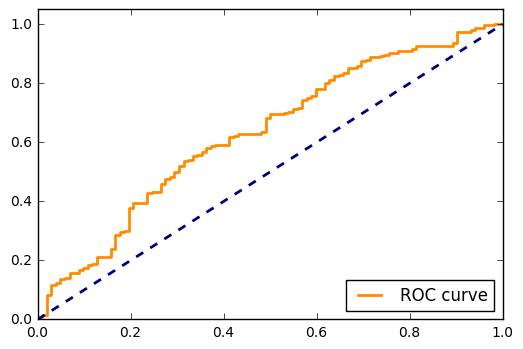


Running cross validation for fold 5:
Train Score: 0.814809 Test Score: 0.575226
AU-ROC 0.575225806452

Optimum threshold to maximize training accuracy: 0.587872612035
F1: 0.749003984064
Accuracy: 0.632653061224
Confusion Matrix:
 [[ 29  64]
 [ 62 188]]

Optimum threshold to maximize f1: 0.521033360654
F1: 0.786389413989
Accuracy: 0.67055393586
Confusion Matrix:
 [[ 22  71]
 [ 42 208]]
None


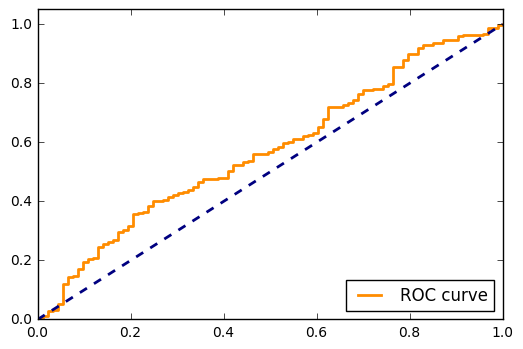


Running cross validation for fold 6:
Train Score: 0.817511 Test Score: 0.539613
AU-ROC 0.539613225203

Optimum threshold to maximize training accuracy: 0.53471762881
F1: 0.744939271255
Accuracy: 0.630498533724
Confusion Matrix:
 [[ 31  81]
 [ 45 184]]

Optimum threshold to maximize f1: 0.504193520825
F1: 0.757396449704
Accuracy: 0.639296187683
Confusion Matrix:
 [[ 26  86]
 [ 37 192]]
None


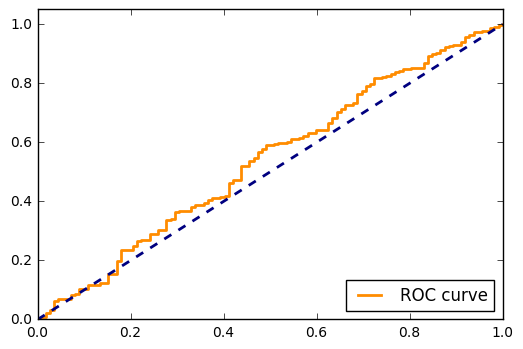


Running cross validation for fold 7:
Train Score: 0.830328 Test Score: 0.540248
AU-ROC 0.540247933884

Optimum threshold to maximize training accuracy: 0.592596971798
F1: 0.725409836066
Accuracy: 0.608187134503
Confusion Matrix:
 [[ 31  69]
 [ 65 177]]

Optimum threshold to maximize f1: 0.548459752874
F1: 0.754940711462
Accuracy: 0.637426900585
Confusion Matrix:
 [[ 27  73]
 [ 51 191]]
None


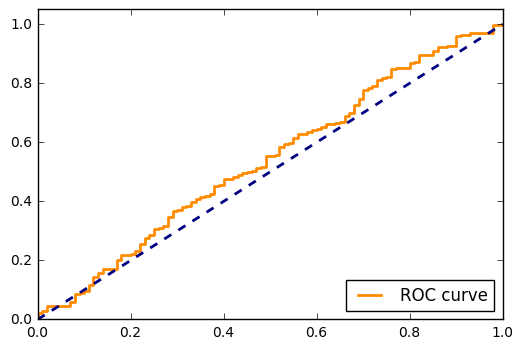

In [17]:
scores, topvals = evalr.kfold(7, True)

Below are the training and testing F1 scores for each fold of cross validation:

In [19]:
print (scores)
print ("Train:", np.mean(scores.Train_score))
print ("Test:", np.mean(scores.Test_score))

  Train_score Test_score
1    0.817112   0.593381
2    0.822403   0.532992
3    0.819964   0.529701
4    0.812963   0.632149
5    0.814809   0.575226
6    0.817511   0.539613
7    0.830328   0.540248
Train: 0.819298499925
Test: 0.563329840608


In addition to training a predictive model, we'd also like to be able to make inference about which of the features in our CGT matrix are most informative for predicting Austism status.  The following are the top 10 genes with the greatest average odds ratios (i.e. farthest from 1). In order to make statistical inference, however, we should calculate a Wald statistic for each feature and search for the most significantly predictive features using multiple hypothesis testing correction.

In [20]:
print (topvals)

['KRT43P', 'CTD-2130O13.1', 'CYP4B1', 'VCX3A', 'MAGEE2', 'CXorf58', 'KRTAP1-5', 'GBGT1']


## Regularization

Since our testing performance f1-scores are still about .1 below our training scores, it makes some sense to look into tuning our regularization parameter $C$ to avoid overfit.  I've written a function below, `reg_plot`, which performs 5 fold cross validation for models with different values of $C$.  

**Note** Recall that $C$ is the inverse of the cannonical regularization parameter, $\lambda$, so that smaller $C$ corresponds to stronger regularization.

In [25]:
# create a plot of preformance versus f1 score for different c values
def reg_plot(c_vals, X_train, y_train, resample = False):
    c_scores = []
    print ("Running 7-fold cross validation for:")
    for i in range(len(c_vals)):
        print( "C = %f" % c_vals[i])
        evalr = EvalLR(X_train, y_train, c = c_vals[i], metric = 'roc')
        c_scores.append(np.mean(evalr.kfold(7, False, False, resample)[0].Test_score))

    plt.clf()
    plt.ylabel('mean cross validation f1 score')
    plt.xlabel('Regularization parameter C')
    plt.plot(c_vals, c_scores, linestyle = '-')
    plt.show()
    plt.figure(figsize=(10,10))
    return c_vals[c_scores.index(max(c_scores))]

Running 7-fold cross validation for:
C = 32.000000
C = 16.000000
C = 8.000000
C = 4.000000
C = 2.000000
C = 0.500000
C = 0.250000
C = 0.125000
C = 0.062500
C = 0.031250


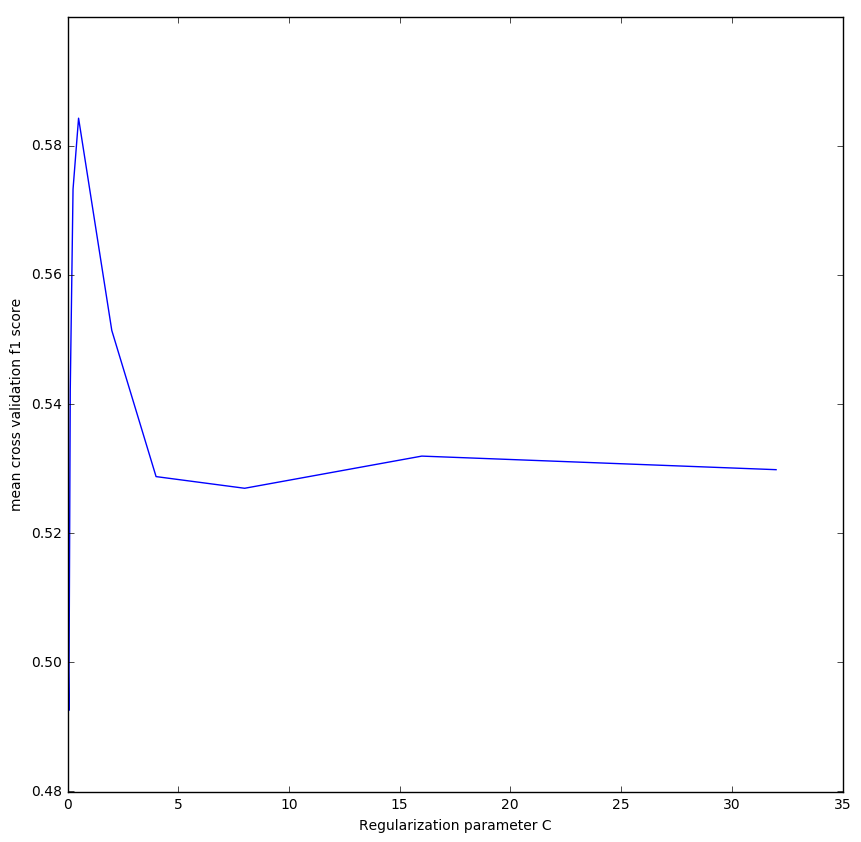

0.5


In [26]:
c_vals = [2**5, 2**4, 2**3, 2**2, 2, 2**-1, 2**-2, 2**-3, 2**-4, 2**-5]
c_opt = reg_plot(c_vals, X_train, y_train)
print (c_opt)

These results suggest that stronger regularization may improve performance.  Let's try again with the optimum from the graph above:


Running cross validation for fold 1:
Train Score: 0.767906 Test Score: 0.574113
AU-ROC 0.574112567957

Optimum threshold to maximize training accuracy: 0.572328781554
F1: 0.777562862669
Accuracy: 0.663742690058
Confusion Matrix:
 [[ 26  80]
 [ 35 201]]


C:\Users\Christine\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Optimum threshold to maximize f1: 0.516823968125
F1: 0.788888888889
Accuracy: 0.666666666667
Confusion Matrix:
 [[ 15  91]
 [ 23 213]]
None


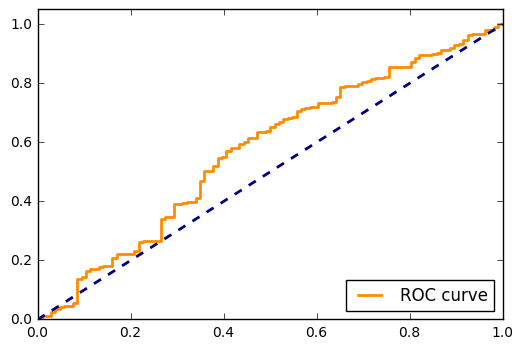


Running cross validation for fold 2:
Train Score: 0.772311 Test Score: 0.599136
AU-ROC 0.599135802469

Optimum threshold to maximize training accuracy: 0.608704280814
F1: 0.765285996055
Accuracy: 0.65306122449
Confusion Matrix:
 [[ 30  70]
 [ 49 194]]

Optimum threshold to maximize f1: 0.532842756621
F1: 0.821818181818
Accuracy: 0.714285714286
Confusion Matrix:
 [[ 19  81]
 [ 17 226]]
None


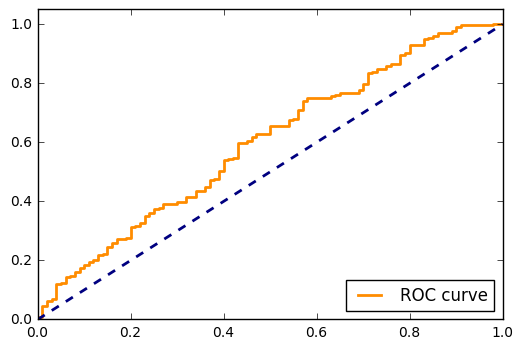


Running cross validation for fold 3:
Train Score: 0.769157 Test Score: 0.563094
AU-ROC 0.563094054484

Optimum threshold to maximize training accuracy: 0.623904269145
F1: 0.732510288066
Accuracy: 0.619883040936
Confusion Matrix:
 [[ 34  73]
 [ 57 178]]

Optimum threshold to maximize f1: 0.516218989795
F1: 0.811111111111
Accuracy: 0.701754385965
Confusion Matrix:
 [[ 21  86]
 [ 16 219]]
None


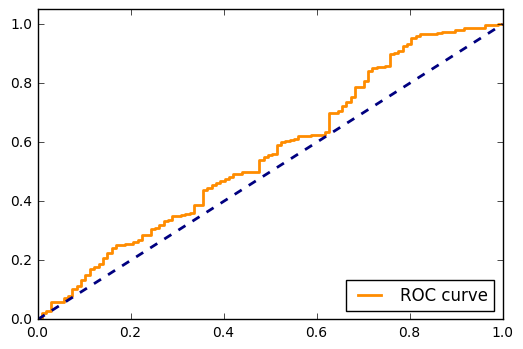


Running cross validation for fold 4:
Train Score: 0.770412 Test Score: 0.575106
AU-ROC 0.575106168732

Optimum threshold to maximize training accuracy: 0.589506048025
F1: 0.778398510242
Accuracy: 0.652046783626
Confusion Matrix:
 [[ 14  77]
 [ 42 209]]

Optimum threshold to maximize f1: 0.531160127689
F1: 0.8078994614
Accuracy: 0.687134502924
Confusion Matrix:
 [[ 10  81]
 [ 26 225]]
None


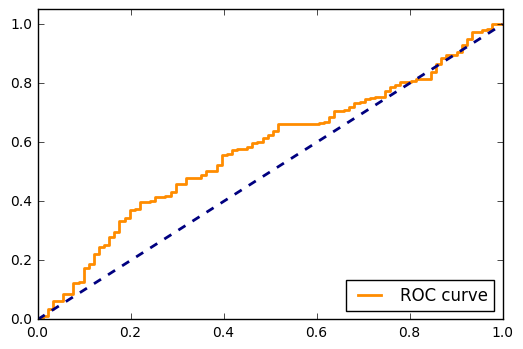


Running cross validation for fold 5:
Train Score: 0.778130 Test Score: 0.553112
AU-ROC 0.553111565591

Optimum threshold to maximize training accuracy: 0.558811560474
F1: 0.776735459662
Accuracy: 0.654069767442
Confusion Matrix:
 [[ 18  79]
 [ 40 207]]

Optimum threshold to maximize f1: 0.538238347981
F1: 0.789667896679
Accuracy: 0.668604651163
Confusion Matrix:
 [[ 16  81]
 [ 33 214]]
None


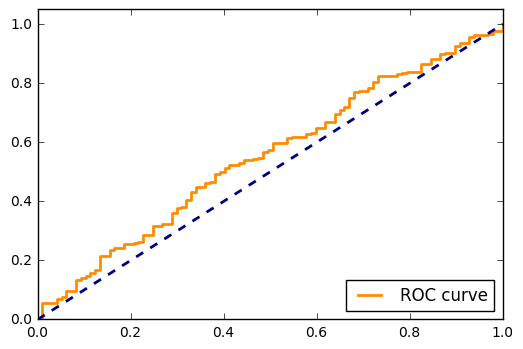


Running cross validation for fold 6:
Train Score: 0.770708 Test Score: 0.561481
AU-ROC 0.561480794497

Optimum threshold to maximize training accuracy: 0.556779384242
F1: 0.787878787879
Accuracy: 0.671554252199
Confusion Matrix:
 [[ 21  93]
 [ 19 208]]

Optimum threshold to maximize f1: 0.556779384242
F1: 0.787878787879
Accuracy: 0.671554252199
Confusion Matrix:
 [[ 21  93]
 [ 19 208]]
None


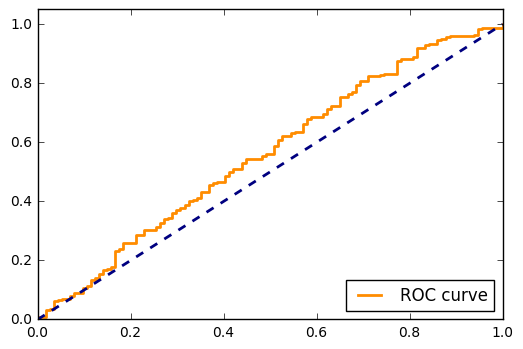


Running cross validation for fold 7:
Train Score: 0.761329 Test Score: 0.636950
AU-ROC 0.636949984172

Optimum threshold to maximize training accuracy: 0.58330620828
F1: 0.776470588235
Accuracy: 0.666666666667
Confusion Matrix:
 [[ 30  78]
 [ 36 198]]

Optimum threshold to maximize f1: 0.52886191637
F1: 0.795497185741
Accuracy: 0.681286549708
Confusion Matrix:
 [[ 21  87]
 [ 22 212]]
None


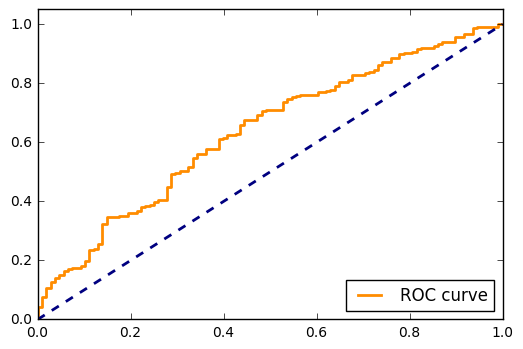

In [30]:
evalr = EvalLR(X_train, y_train, c = c_opt)
scores, topgenes = evalr.kfold(7, True)

In [31]:
print (scores)
print ("Train:", np.mean(scores.Train_score))
print ("Test:", np.mean(scores.Test_score))

  Train_score Test_score
1    0.767906   0.574113
2    0.772311   0.599136
3    0.769157   0.563094
4    0.770412   0.575106
5     0.77813   0.553112
6    0.770708   0.561481
7    0.761329    0.63695
Train: 0.769993186189
Test: 0.580427276843


In [32]:
print (topgenes)

['OR1S1', 'AP002856.6', 'KRTAP29-1', 'RP11-404K5.2', 'RP11-87M18.2', 'CXorf58', 'MAGEE2', 'VCX3A']


## Resampling data to address class imbalance

Right now, we have a class imbalance problem because we tend to have many more autistic than non-autistic people in our dataset.  In general, we currently have two autistic subjects for every control subject in our training set:

In [33]:
y_train.value_counts()

1.0    1673
0.0     723
Name: diagnosis, dtype: int64

One approach to address this problem is to resample from our data so that there is a 1:1 raio between austistic subjects and non-autistic controls.  In this implementation, I oversample the neurotypical subjects; that is, the positive subjects in the training data remain the same, but I sample with replacement from the neurotypical subjects in the training set for each fold so that there are as many controls as ASD cases in both the training and testing sets.

Now we can retrain our model with resampled data:

In [35]:
# Import EvalLR
import class_EvalLR
#reload(class_EvalLR)
from class_EvalLR import EvalLR

Oversampling from negative controls to 1:1 balance
Oversampling from negative controls to 1:1 balance

Running cross validation for fold 1:
Train Score: 0.893604 Test Score: 0.505733
AU-ROC 0.505732527223

Optimum threshold to maximize training accuracy: 0.503606770971
F1: 0.552346570397
Accuracy: 0.489711934156
Confusion Matrix:
 [[ 85 158]
 [ 90 153]]


C:\Users\Christine\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Optimum threshold to maximize f1: 0.413026519003
F1: 0.57525083612
Accuracy: 0.477366255144
Confusion Matrix:
 [[ 60 183]
 [ 71 172]]
None


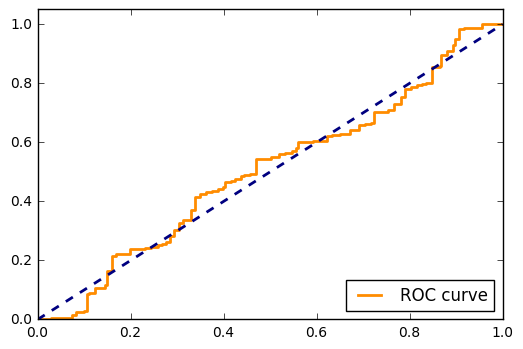

Oversampling from negative controls to 1:1 balance
Oversampling from negative controls to 1:1 balance

Running cross validation for fold 2:
Train Score: 0.893401 Test Score: 0.581160
AU-ROC 0.581159587565

Optimum threshold to maximize training accuracy: 0.476969826277
F1: 0.602996254682
Accuracy: 0.535087719298
Confusion Matrix:
 [[ 83 145]
 [ 67 161]]

Optimum threshold to maximize f1: 0.476969826277
F1: 0.602996254682
Accuracy: 0.535087719298
Confusion Matrix:
 [[ 83 145]
 [ 67 161]]
None


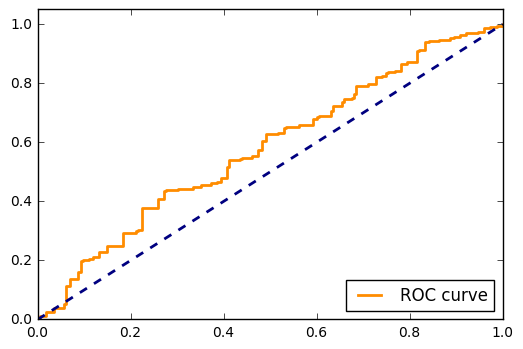

Oversampling from negative controls to 1:1 balance
Oversampling from negative controls to 1:1 balance

Running cross validation for fold 3:
Train Score: 0.885542 Test Score: 0.519610
AU-ROC 0.519610461286

Optimum threshold to maximize training accuracy: 0.471585405551
F1: 0.567619047619
Accuracy: 0.521097046414
Confusion Matrix:
 [[ 98 139]
 [ 88 149]]

Optimum threshold to maximize f1: 0.469483616131
F1: 0.564971751412
Accuracy: 0.512658227848
Confusion Matrix:
 [[ 93 144]
 [ 87 150]]
None


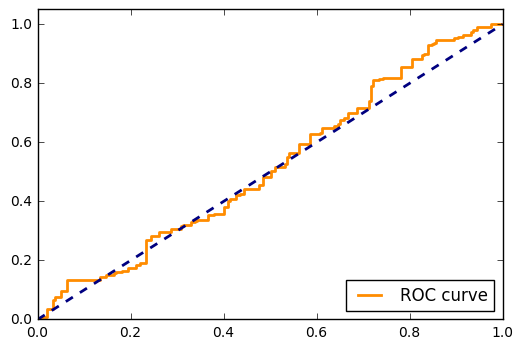

Oversampling from negative controls to 1:1 balance
Oversampling from negative controls to 1:1 balance

Running cross validation for fold 4:
Train Score: 0.881455 Test Score: 0.552927
AU-ROC 0.552927053174

Optimum threshold to maximize training accuracy: 0.486568666232
F1: 0.621669626998
Accuracy: 0.552521008403
Confusion Matrix:
 [[ 88 150]
 [ 63 175]]

Optimum threshold to maximize f1: 0.483074073026
F1: 0.624113475177
Accuracy: 0.554621848739
Confusion Matrix:
 [[ 88 150]
 [ 62 176]]
None


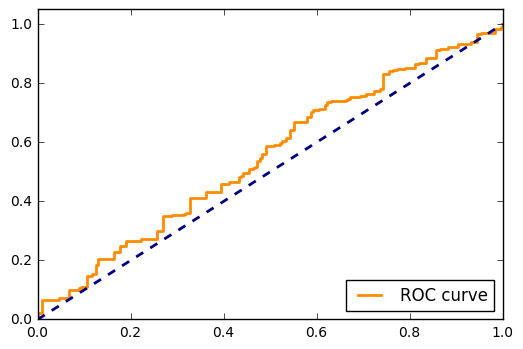

Oversampling from negative controls to 1:1 balance
Oversampling from negative controls to 1:1 balance

Running cross validation for fold 5:
Train Score: 0.892625 Test Score: 0.524623
AU-ROC 0.524622635066

Optimum threshold to maximize training accuracy: 0.506084218949
F1: 0.575091575092
Accuracy: 0.520661157025
Confusion Matrix:
 [[ 95 147]
 [ 85 157]]

Optimum threshold to maximize f1: 0.446772406231
F1: 0.595818815331
Accuracy: 0.520661157025
Confusion Matrix:
 [[ 81 161]
 [ 71 171]]
None


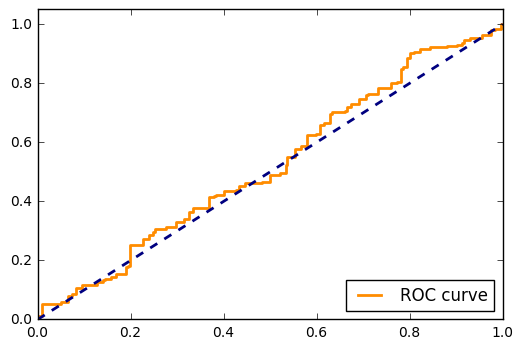

Oversampling from negative controls to 1:1 balance
Oversampling from negative controls to 1:1 balance

Running cross validation for fold 6:
Train Score: 0.877090 Test Score: 0.584159
AU-ROC 0.584158918864

Optimum threshold to maximize training accuracy: 0.504066672097
F1: 0.586206896552
Accuracy: 0.555555555556
Confusion Matrix:
 [[117 126]
 [ 90 153]]

Optimum threshold to maximize f1: 0.428774803601
F1: 0.604316546763
Accuracy: 0.547325102881
Confusion Matrix:
 [[ 98 145]
 [ 75 168]]
None


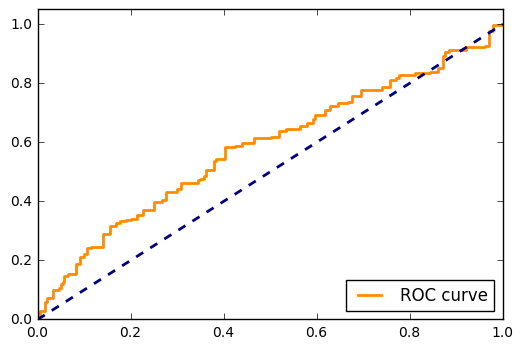

Oversampling from negative controls to 1:1 balance
Oversampling from negative controls to 1:1 balance

Running cross validation for fold 7:
Train Score: 0.886201 Test Score: 0.517349
AU-ROC 0.517348541766

Optimum threshold to maximize training accuracy: 0.541330475907
F1: 0.589981447124
Accuracy: 0.543388429752
Confusion Matrix:
 [[104 138]
 [ 83 159]]

Optimum threshold to maximize f1: 0.438512356736
F1: 0.614564831261
Accuracy: 0.551652892562
Confusion Matrix:
 [[ 94 148]
 [ 69 173]]
None


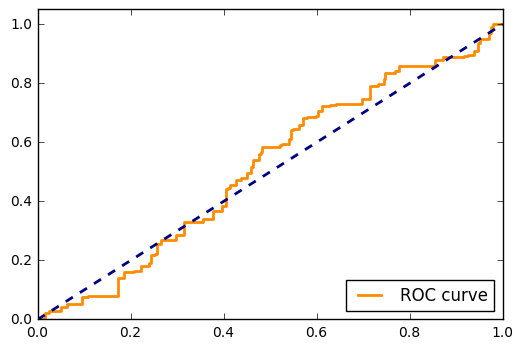

In [36]:
evalr = EvalLR(X_train, y_train)
scores, topgenes = evalr.kfold(7, makeROC = True, resample = True)

In [38]:
print (scores)
print ("Train:", np.mean(scores.Train_score))
print ("Test:", np.mean(scores.Test_score))

  Train_score Test_score
1    0.893604   0.505733
2    0.893401    0.58116
3    0.885542    0.51961
4    0.881455   0.552927
5    0.892625   0.524623
6     0.87709   0.584159
7    0.886201   0.517349
Train: 0.887131138519
Test: 0.540794246421


After resampling, the ROC curves look about the same.  The average training score is increased, and the average testing error is about the same as before resampling with this regularization parameter. 

We can tune the regularization parameter as we did before:

Running 7-fold cross validation for:
C = 32.000000
C = 16.000000
C = 8.000000
C = 4.000000
C = 2.000000
C = 0.500000
C = 0.250000
C = 0.125000
C = 0.062500
C = 0.031250


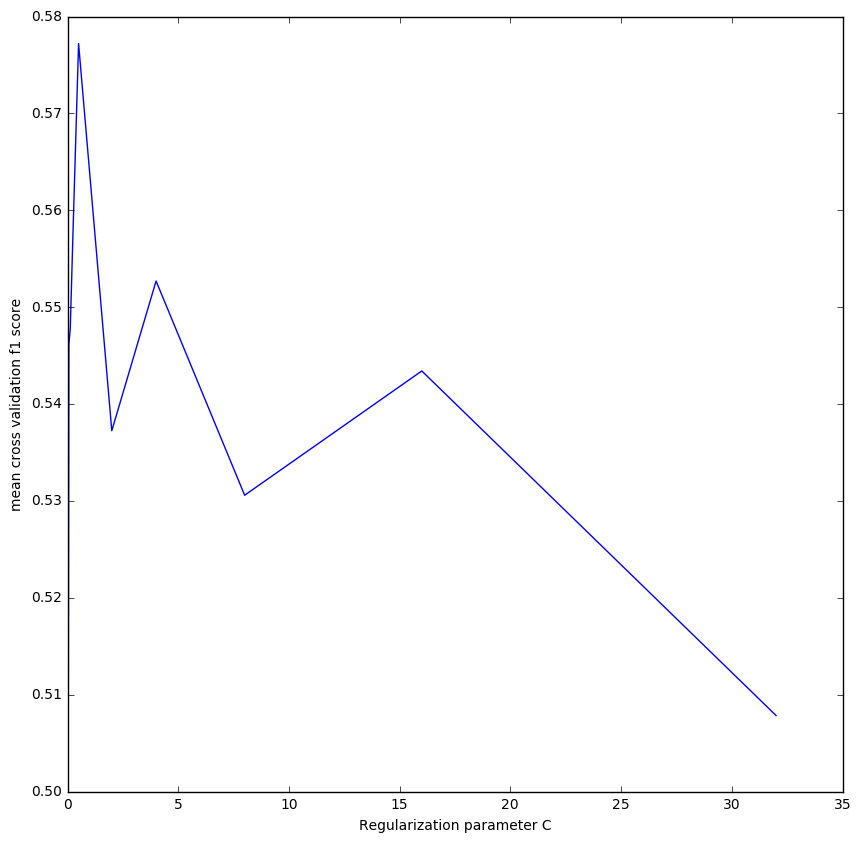

0.5


In [40]:
c_vals = [2**5, 2**4, 2**3, 2**2, 2, 2**-1, 2**-2, 2**-3, 2**-4, 2**-5]
c_opt = reg_plot(c_vals, X_train, y_train, resample = True)
print (c_opt)

Oversampling from negative controls to 1:1 balance
Oversampling from negative controls to 1:1 balance

Running cross validation for fold 1:
Train Score: 0.842481 Test Score: 0.532153
AU-ROC 0.532153372015

Optimum threshold to maximize training accuracy: 0.513259992394
F1: 0.560606060606
Accuracy: 0.51867219917
Confusion Matrix:
 [[102 139]
 [ 93 148]]


C:\Users\Christine\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Optimum threshold to maximize f1: 0.464308911823
F1: 0.591065292096
Accuracy: 0.50622406639
Confusion Matrix:
 [[ 72 169]
 [ 69 172]]
None


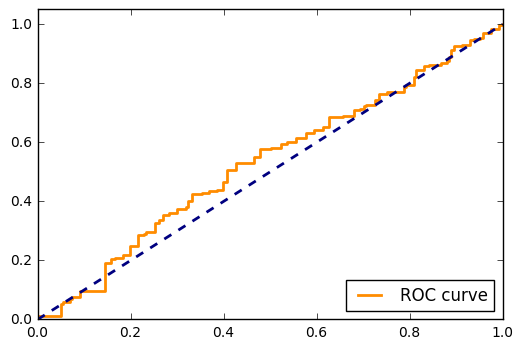

Oversampling from negative controls to 1:1 balance
Oversampling from negative controls to 1:1 balance

Running cross validation for fold 2:
Train Score: 0.845322 Test Score: 0.527621
AU-ROC 0.52762052225

Optimum threshold to maximize training accuracy: 0.489787144212
F1: 0.602006688963
Accuracy: 0.522088353414
Confusion Matrix:
 [[ 80 169]
 [ 69 180]]

Optimum threshold to maximize f1: 0.408931989546
F1: 0.612368024133
Accuracy: 0.483935742972
Confusion Matrix:
 [[ 38 211]
 [ 46 203]]
None


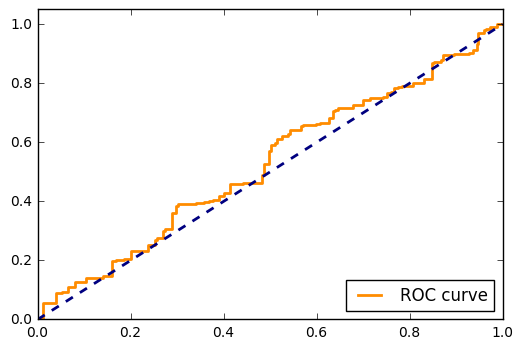

Oversampling from negative controls to 1:1 balance
Oversampling from negative controls to 1:1 balance

Running cross validation for fold 3:
Train Score: 0.842804 Test Score: 0.541473
AU-ROC 0.541473054532

Optimum threshold to maximize training accuracy: 0.529158370669
F1: 0.56338028169
Accuracy: 0.542194092827
Confusion Matrix:
 [[117 120]
 [ 97 140]]

Optimum threshold to maximize f1: 0.477912567962
F1: 0.592321755027
Accuracy: 0.529535864979
Confusion Matrix:
 [[ 89 148]
 [ 75 162]]
None


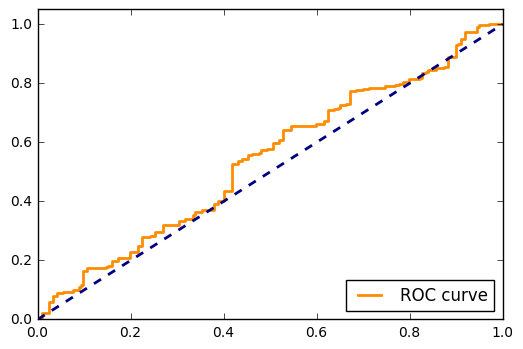

Oversampling from negative controls to 1:1 balance
Oversampling from negative controls to 1:1 balance

Running cross validation for fold 4:
Train Score: 0.829788 Test Score: 0.583794
AU-ROC 0.583793571752

Optimum threshold to maximize training accuracy: 0.457069905469
F1: 0.616513761468
Accuracy: 0.555319148936
Confusion Matrix:
 [[ 93 142]
 [ 67 168]]

Optimum threshold to maximize f1: 0.457069905469
F1: 0.616513761468
Accuracy: 0.555319148936
Confusion Matrix:
 [[ 93 142]
 [ 67 168]]
None


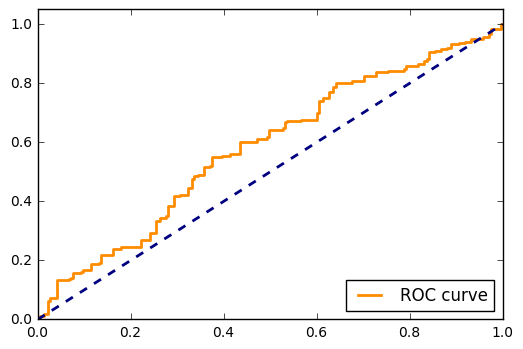

Oversampling from negative controls to 1:1 balance
Oversampling from negative controls to 1:1 balance

Running cross validation for fold 5:
Train Score: 0.839109 Test Score: 0.568873
AU-ROC 0.568872509747

Optimum threshold to maximize training accuracy: 0.478787299166
F1: 0.619402985075
Accuracy: 0.569620253165
Confusion Matrix:
 [[104 133]
 [ 71 166]]

Optimum threshold to maximize f1: 0.476143069098
F1: 0.619402985075
Accuracy: 0.569620253165
Confusion Matrix:
 [[104 133]
 [ 71 166]]
None


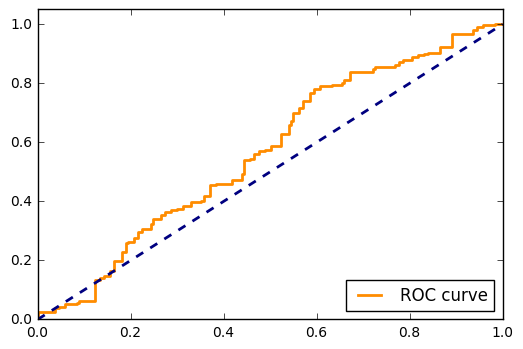

Oversampling from negative controls to 1:1 balance
Oversampling from negative controls to 1:1 balance

Running cross validation for fold 6:
Train Score: 0.843067 Test Score: 0.545691
AU-ROC 0.545690655566

Optimum threshold to maximize training accuracy: 0.52777445137
F1: 0.553278688525
Accuracy: 0.532188841202
Confusion Matrix:
 [[113 120]
 [ 98 135]]

Optimum threshold to maximize f1: 0.455960586523
F1: 0.598165137615
Accuracy: 0.530042918455
Confusion Matrix:
 [[ 84 149]
 [ 70 163]]
None


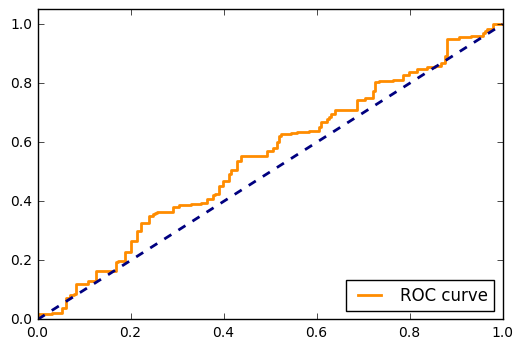

Oversampling from negative controls to 1:1 balance
Oversampling from negative controls to 1:1 balance

Running cross validation for fold 7:
Train Score: 0.840986 Test Score: 0.485219
AU-ROC 0.485218918407

Optimum threshold to maximize training accuracy: 0.517053870546
F1: 0.516981132075
Accuracy: 0.46887966805
Confusion Matrix:
 [[ 89 152]
 [104 137]]

Optimum threshold to maximize f1: 0.418091225809
F1: 0.581280788177
Accuracy: 0.470954356846
Confusion Matrix:
 [[ 50 191]
 [ 64 177]]
None


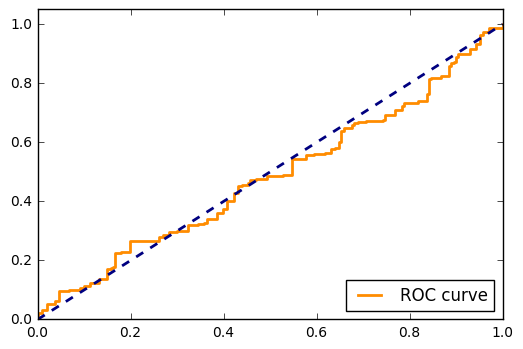

In [41]:
evalr = EvalLR(X_train, y_train, c = c_opt)
scores, topgenes = evalr.kfold(7, makeROC = True, resample = True)

In [42]:
print (scores)
print ("Train:", np.mean(scores.Train_score))
print ("Test:", np.mean(scores.Test_score))

  Train_score Test_score
1    0.842481   0.532153
2    0.845322   0.527621
3    0.842804   0.541473
4    0.829788   0.583794
5    0.839109   0.568873
6    0.843067   0.545691
7    0.840986   0.485219
Train: 0.840508181194
Test: 0.540688943467


# Testing


Optimum threshold to maximize f1: 0.408372530713
Train Score: 0.691609 Test Score: 0.666062
AU-ROC: 0.573164378615
Accuracy: 0.552311435523
Confusion Matrix:
[[ 87 324]
 [ 44 367]]


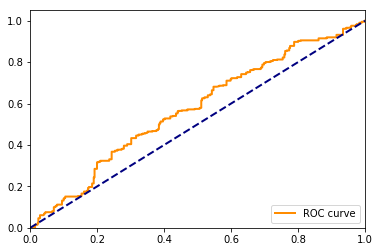

In [45]:
random.seed(143)
evalr = EvalLR(X_train, y_train, c=c_opt)
rXtrain, rytrain = evalr.resample(X_train, y_train, False)
rXtest, rytest = evalr.resample(X_test, y_test, False)
evalr.setTrain(rXtrain, np.asarray(rytrain))
evalr.setTest(rXtest, rytest)


from sklearn.metrics import roc_curve, f1_score, confusion_matrix
# fit to train data
evalr.lr.fit(rXtrain, rytrain)

test_probs = evalr.lr.predict_proba(rXtest)[:,1]
train_probs = evalr.lr.predict_proba(rXtrain)[:,1]

fpr, tpr, thresholds = roc_curve(rytrain, train_probs, pos_label = 1)
f1s = [f1_score(rytrain, (train_probs>t).astype(int), average = 'binary') for t in thresholds]
f_i = np.argmax(np.asarray(f1s))

test_probs_f = (test_probs>thresholds[f_i]).astype(int)
print "\nOptimum threshold to maximize f1:", thresholds[f_i]
trainscore = f1_score(rytrain, (train_probs>thresholds[f_i]).astype(int), average = 'binary')
testscore = f1_score(rytest, test_probs_f, average = 'binary')

print "Train Score: %f Test Score: %f" % (trainscore, testscore)

print "AU-ROC:", roc_auc_score(rytest, test_probs)
print "Accuracy:", accuracy_score(rytest, test_probs_f)
print "Confusion Matrix:\n", confusion_matrix(rytest, test_probs_f)

plt.figure()
lw = 2


fpr, tpr, thresholds = roc_curve(rytest, test_probs, pos_label = 1)
plt.plot(fpr, tpr, color = 'darkorange', lw = lw, label = 'ROC curve')
plt.plot([0,1], [0,1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.legend(loc='lower right')
plt.show()
plt.figure(figsize = (10,10))

## Improvements

The following changes might be good to think about:
- continue to improve EvalLR for fine-tuning regression models.
- use sklearn implementation for GroupKFold to streamline code.
- get wald statistic to detect important features
- try other regression methods
- Generate precision-recall curves